In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv("group.csv", sep = ",")
df2 = pd.read_csv("AQI.csv", sep = ",")

In [3]:
df1

,Date,Country,City,Specie,count,min,max,median,variance,IAQI_CO,IAQI_SO2,IAQI_NO2,IAQI_O3,IAQI_PM25,IAQI_PM10
0,2021/12/27,CN,Lanzhou,co,70,5.5,70.9,14.5,1129.84,153,15,19,8,21,15
1,2021/12/27,CN,Lanzhou,dew,66,-22.0,-14.0,-20.0,84.67,-500,-20,-25,-10,-29,-20
2,2021/12/27,CN,Lanzhou,humidity,72,45.0,77.0,65.0,845.85,0,58,82,33,88,58
3,2021/12/27,CN,Lanzhou,no2,71,10.1,50.4,28.8,810.59,240,29,36,15,42,29
4,2021/12/27,CN,Lanzhou,o3,71,0.9,24.4,4.5,384.74,103,5,6,3,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,2022/11/30,CN,Lanzhou,pm25,72,65.0,144.0,91.0,2849.53,0,71,106,46,120,71
3788,2022/11/30,CN,Lanzhou,pressure,72,1026.0,1030.0,1028.0,14.08,0,229,0,0,0,0
3789,2022/11/30,CN,Lanzhou,so2,69,5.6,27.4,13.2,163.98,146,14,17,7,19,14
3790,2022/11/30,CN,Lanzhou,temperature,72,-16.0,-7.0,-13.0,88.15,-325,-13,-17,-7,-19,-13


In [4]:
df2

,AQI,pollutionlevel
0,199,4
1,206,5
2,208,5
3,213,5
4,168,4
...,...,...
334,156,4
335,196,4
336,120,3
337,113,3


In [5]:
df_dew = df1[df1['Specie'] == "dew"]['median']
df_humidity = df1[df1['Specie'] == "humidity"]['median']
df_pressure = df1[df1['Specie'] == "pressure"]['median']
df_temperature = df1[df1['Specie'] == "temperature"]['median']
df_windspeed = df1[df1['Specie'] == "windspeed"]['median']
df_y = df2['pollutionlevel']

In [6]:
X = np.column_stack((df_dew, df_humidity, df_pressure, df_temperature, df_windspeed))
y = df_y = df2['pollutionlevel']

In [7]:
print(X.shape)

(339, 5)


In [8]:
def LR_Poly_l1(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('log_reg', LogisticRegression(C = C, penalty = 'l1', solver = 'saga'))
    ])

In [9]:
def LR_Poly_l2(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('log_reg', LogisticRegression(C = C, penalty = 'l2', solver = 'saga'))
    ])

In [10]:
def SVC_Poly(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('SVC', LinearSVC(C=C))
    ])

In [11]:
def CrossValidation(X, y, degree, C_range):
    poly = PolynomialFeatures(degree)
    X_train = poly.fit_transform(X)

    mean_error_LR = []
    f1_score_LR = []
    std_error_LR = []
    mean_error_LR2 = []
    f1_score_LR2 = []
    std_error_LR2 = []
    mean_error_SVC = []
    f1_score_SVC = []
    std_error_SVC = []
    mean_error_1 = []
    f1_score_1 = []
    std_error_1 = []
    mean_error_2 = []
    f1_score_2 = []
    std_error_2 = []

    kf = KFold(n_splits = 5)
    for C in C_range:
        model_LR_KF = LR_Poly_l1(degree = degree, C = C)
        temp_LR = []
        temp_f1_LR = []
        model_LR2_KF = LR_Poly_l2(degree = degree, C = C)
        temp_LR2 = []
        temp_f1_LR2 = []
        model_SVC_KF = SVC_Poly(degree = degree, C = C)
        temp_SVC = []
        temp_f1_SVC = []
        model_frequent_KF = DummyClassifier(strategy='constant', constant = 4)
        temp_1 = []
        temp_f1_1 = []
        model_uniform_KF = DummyClassifier(strategy='uniform')
        temp_2 = []
        temp_f1_2 = []
        for train, test in kf.split(X_train):
            model_LR_KF.fit(X_train[train], y[train])
            y_predict_LR_kf = model_LR_KF.predict(X_train[test])
            temp_LR.append(mean_squared_error(y[test], y_predict_LR_kf))
            temp_f1_LR.append(fbeta_score(y[test], y_predict_LR_kf, average = 'micro', beta = 1))
            
            model_LR2_KF.fit(X_train[train], y[train])
            y_predict_LR2_kf = model_LR2_KF.predict(X_train[test])
            temp_LR2.append(mean_squared_error(y[test], y_predict_LR2_kf))
            temp_f1_LR2.append(fbeta_score(y[test], y_predict_LR2_kf, average = 'micro', beta = 1))
            
            model_SVC_KF.fit(X_train[train], y[train])
            y_predict_SVC_kf = model_SVC_KF.predict(X_train[test])
            temp_SVC.append(mean_squared_error(y[test], y_predict_SVC_kf))
            temp_f1_SVC.append(fbeta_score(y[test], y_predict_SVC_kf, average = 'micro', beta = 1))           

            model_frequent_KF.fit(X_train[train], y[train])
            y_predict_MF_kf = model_frequent_KF.predict(X_train[test])
            temp_1.append(mean_squared_error(y[test], y_predict_MF_kf))
            temp_f1_1.append(fbeta_score(y[test], y_predict_MF_kf, average = 'micro', beta = 1)) 

            model_uniform_KF.fit(X_train[train], y[train])
            y_predict_MU_kf = model_uniform_KF.predict(X_train[test])
            temp_2.append(mean_squared_error(y[test], y_predict_MU_kf))
            temp_f1_2.append(fbeta_score(y[test], y_predict_MU_kf, average = 'micro', beta = 1)) 
            
        std_error_LR.append(np.array(temp_f1_LR).std())
        f1_score_LR.append(np.array(temp_f1_LR).mean())
        y_predict_LR = model_LR_KF.predict(X_train)
        
        std_error_LR2.append(np.array(temp_f1_LR2).std())
        f1_score_LR2.append(np.array(temp_f1_LR2).mean())
        y_predict_LR2 = model_LR2_KF.predict(X_train)
        
        std_error_SVC.append(np.array(temp_f1_SVC).std())
        f1_score_SVC.append(np.array(temp_f1_SVC).mean())
        y_predict_SVC = model_SVC_KF.predict(X_train)
        
        std_error_1.append(np.array(temp_f1_1).std())
        f1_score_1.append(np.array(temp_f1_1).mean())
        y_predict_1 = model_frequent_KF.predict(X_train)
        
        std_error_2.append(np.array(temp_f1_2).std())
        f1_score_2.append(np.array(temp_f1_2).mean())
        y_predict_2 = model_uniform_KF.predict(X_train)
    
    
    plt.figure(1)
    plt.title('Cross-validation for degree = %d' %(degree))
    plt.errorbar(np.log(C_range), f1_score_LR, yerr = std_error_LR, 
                 label = 'Logistic Regression(L1)', alpha = 0.5)
    plt.errorbar(np.log(C_range), f1_score_LR2, yerr = std_error_LR2, 
                 label = 'Logistic Regression(L2)', alpha = 0.5)
    plt.errorbar(np.log(C_range), f1_score_SVC, yerr = std_error_SVC, 
                 label = 'Linear SVC')
    plt.errorbar(np.log(C_range), f1_score_1, yerr = std_error_1, 
                 label = 'Baseline: Constant = 4')
    plt.errorbar(np.log(C_range), f1_score_2, yerr = std_error_2, 
                 label = 'Baseline: Uniformly Random')
    plt.legend(loc = 'lower left')
    plt.xlabel('log(C)')
    plt.ylabel('F1 Score')
    plt.plot()
    
    plt.show()
    
    print(f1_score_LR)
    print(f1_score_LR2)
    print(f1_score_SVC)
    print(f1_score_1)
    print(f1_score_2)

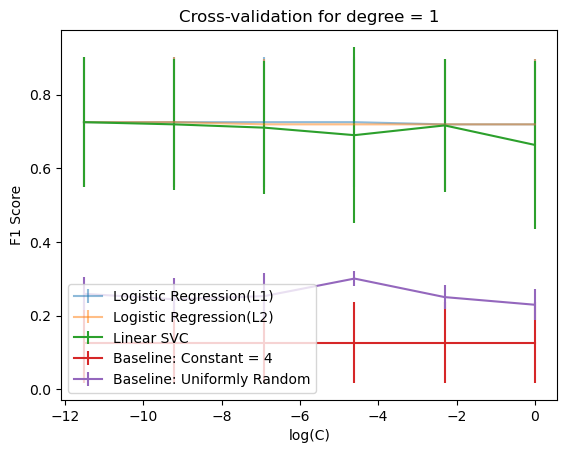

[0.7256365232660229, 0.7256365232660229, 0.7256365232660229, 0.7256365232660229, 0.7196663740122915, 0.7196663740122915]
[0.7256365232660229, 0.7256365232660229, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915]
[0.7256365232660229, 0.7196663740122915, 0.7107111501316945, 0.6903424056189641, 0.7168129938542581, 0.6638279192273925]
[0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054]
[0.25956979806848113, 0.24473222124670763, 0.2533801580333626, 0.3009657594381036, 0.2506584723441615, 0.22989464442493418]


In [12]:
CrossValidation(X, y, 1, [0.00001, 0.0001, 0.001, 0.01, 0.1, 1])

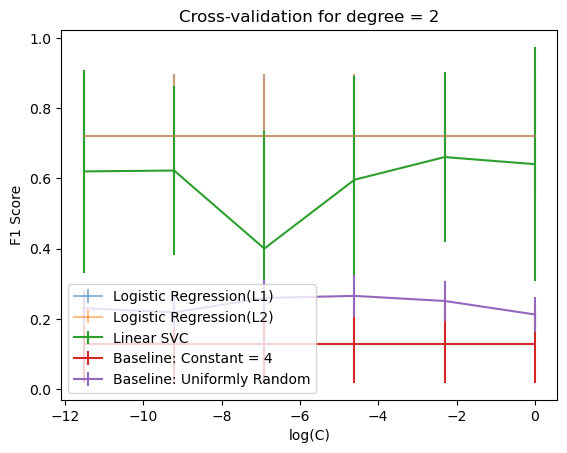

[0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915]
[0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915, 0.7196663740122915]
[0.6197541703248464, 0.6222563652326603, 0.4000877963125549, 0.5960930640913082, 0.6605794556628621, 0.640342405618964]
[0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054]
[0.2302897278314311, 0.21848112379280069, 0.2596136962247585, 0.2654082528533802, 0.25092186128182614, 0.21259877085162424]


In [13]:
CrossValidation(X, y, 2, [0.00001, 0.0001, 0.001, 0.01, 0.1, 1])

In [14]:
def OvR_Poly_LR1(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('log_reg', OneVsRestClassifier(LogisticRegression(C = C, penalty = 'l1', solver = 'saga')))
    ])

In [15]:
def OvR_Poly_LR2(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('log_reg', OneVsRestClassifier(LogisticRegression(C = C, penalty = 'l2', solver = 'saga')))
    ])

In [16]:
def OvR_Poly_LR2(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree = degree)),
        ('log_reg', OneVsRestClassifier(LinearSVC(C=C)))
    ])

In [17]:
def CrossValidation_OvR(X, y, degree, C_range):
    poly = PolynomialFeatures(degree)
    X_train = poly.fit_transform(X)

    mean_error_LR = []
    f1_score_LR = []
    std_error_LR = []
    mean_error_LR2 = []
    f1_score_LR2 = []
    std_error_LR2 = []
    mean_error_SVC = []
    f1_score_SVC = []
    std_error_SVC = []
    mean_error_1 = []
    f1_score_1 = []
    std_error_1 = []
    mean_error_2 = []
    f1_score_2 = []
    std_error_2 = []

    kf = KFold(n_splits = 5)
    for C in C_range:
        model_LR_KF = OvR_Poly_LR1(degree = degree, C = C)
        temp_LR = []
        temp_f1_LR = []
        model_LR2_KF = OvR_Poly_LR2(degree = degree, C = C)
        temp_LR2 = []
        temp_f1_LR2 = []
        model_SVC_KF = OvR_Poly_LR2(degree = degree, C = C)
        temp_SVC = []
        temp_f1_SVC = []
        model_frequent_KF = DummyClassifier(strategy='constant', constant = 4)
        temp_1 = []
        temp_f1_1 = []
        model_uniform_KF = DummyClassifier(strategy='uniform')
        temp_2 = []
        temp_f1_2 = []
        for train, test in kf.split(X_train):
            model_LR_KF.fit(X_train[train], y[train])
            y_predict_LR_kf = model_LR_KF.predict(X_train[test])
            temp_LR.append(mean_squared_error(y[test], y_predict_LR_kf))
            temp_f1_LR.append(fbeta_score(y[test], y_predict_LR_kf, average = 'micro', beta = 1))
            
            model_LR2_KF.fit(X_train[train], y[train])
            y_predict_LR2_kf = model_LR2_KF.predict(X_train[test])
            temp_LR2.append(mean_squared_error(y[test], y_predict_LR2_kf))
            temp_f1_LR2.append(fbeta_score(y[test], y_predict_LR2_kf, average = 'micro', beta = 1))
            
            model_SVC_KF.fit(X_train[train], y[train])
            y_predict_SVC_kf = model_SVC_KF.predict(X_train[test])
            temp_SVC.append(mean_squared_error(y[test], y_predict_SVC_kf))
            temp_f1_SVC.append(fbeta_score(y[test], y_predict_SVC_kf, average = 'micro', beta = 1))           

            model_frequent_KF.fit(X_train[train], y[train])
            y_predict_MF_kf = model_frequent_KF.predict(X_train[test])
            temp_1.append(mean_squared_error(y[test], y_predict_MF_kf))
            temp_f1_1.append(fbeta_score(y[test], y_predict_MF_kf, average = 'micro', beta = 1)) 

            model_uniform_KF.fit(X_train[train], y[train])
            y_predict_MU_kf = model_uniform_KF.predict(X_train[test])
            temp_2.append(mean_squared_error(y[test], y_predict_MU_kf))
            temp_f1_2.append(fbeta_score(y[test], y_predict_MU_kf, average = 'micro', beta = 1)) 
            
        std_error_LR.append(np.array(temp_f1_LR).std())
        f1_score_LR.append(np.array(temp_f1_LR).mean())
        y_predict_LR = model_LR_KF.predict(X_train)
        
        std_error_LR2.append(np.array(temp_f1_LR2).std())
        f1_score_LR2.append(np.array(temp_f1_LR2).mean())
        y_predict_LR2 = model_LR2_KF.predict(X_train)
        
        std_error_SVC.append(np.array(temp_f1_SVC).std())
        f1_score_SVC.append(np.array(temp_f1_SVC).mean())
        y_predict_SVC = model_SVC_KF.predict(X_train)
        
        std_error_1.append(np.array(temp_f1_1).std())
        f1_score_1.append(np.array(temp_f1_1).mean())
        y_predict_1 = model_frequent_KF.predict(X_train)
        
        std_error_2.append(np.array(temp_f1_2).std())
        f1_score_2.append(np.array(temp_f1_2).mean())
        y_predict_2 = model_uniform_KF.predict(X_train)
    
    
    plt.figure(1)
    plt.title('Cross-validation for degree = %d' %(degree))
    plt.errorbar(np.log(C_range), f1_score_LR, yerr = std_error_LR, 
                 label = 'Logistic Regression(L1)', alpha = 0.5)
    plt.errorbar(np.log(C_range), f1_score_LR2, yerr = std_error_LR2, 
                 label = 'Logistic Regression(L2)', alpha = 0.5)
    plt.errorbar(np.log(C_range), f1_score_SVC, yerr = std_error_SVC, 
                 label = 'Linear SVC')
    plt.errorbar(np.log(C_range), f1_score_1, yerr = std_error_1, 
                 label = 'Baseline: Constant = 4')
    plt.errorbar(np.log(C_range), f1_score_2, yerr = std_error_2, 
                 label = 'Baseline: Uniformly Random')
    plt.legend(loc = 'lower left')
    plt.xlabel('log(C)')
    plt.ylabel('F1 Score')
    plt.plot()
    
    plt.show()
    
    print(f1_score_LR)
    print(f1_score_LR2)
    print(f1_score_SVC)
    print(f1_score_1)
    print(f1_score_2)

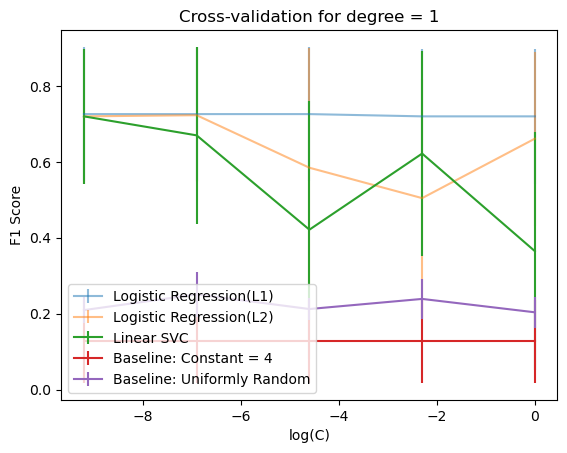

[0.7256365232660229, 0.7256365232660229, 0.7256365232660229, 0.7196663740122915, 0.7196663740122915]
[0.7196663740122915, 0.7226514486391572, 0.5843722563652326, 0.5043459174714662, 0.6609306409130816]
[0.7196663740122915, 0.6696224758560141, 0.4212467076382792, 0.6216856892010536, 0.3647058823529412]
[0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054, 0.12721685689201054]
[0.20943810359964882, 0.2507901668129938, 0.2122914837576822, 0.23889376646180863, 0.2036435469710272]


In [18]:
CrossValidation_OvR(X, y, 1, [0.0001, 0.001, 0.01, 0.1, 1])